In [3]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[classic_control]
!pip install keras-rl2

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.5).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import random
import gym
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
%matplotlib inline

In [5]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


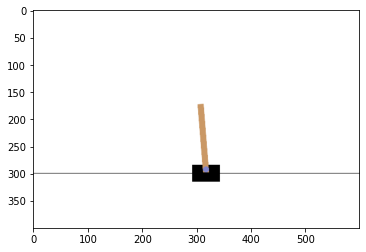

In [7]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(20):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  # if done:
  #   env.reset()
env.close()

In [8]:
nb_actions = env.action_space.n
nb_actions

2

In [9]:
nb_obs = env.observation_space.shape
nb_obs

(4,)

In [10]:
model = Sequential()

model.add(Flatten(input_shape=(1,)+nb_obs))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

# Neurons == action_space
model.add(Dense(nb_actions))
model.add(Activation('linear'))

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 activation_2 (Activation)   (None, 2)                 0

In [16]:
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [14]:
memory = SequentialMemory(limit=20000,window_length=1)

In [17]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
              value_max=1.0,
              value_min=0.1, 
              value_test=0.05,
              nb_steps=20000
              )

In [18]:
dqn = DQNAgent(model=model,nb_actions=nb_actions,
               memory=memory,nb_steps_warmup=10,
               target_model_update=100,policy=policy)

In [19]:
dqn.compile(Adam(learning_rate=1e-3),metrics=['mae'])

In [20]:
dqn.fit(env,nb_steps=20000,visualize=False,verbose=2)

Training for 20000 steps ...
    10/20000: episode: 1, duration: 0.090s, episode steps:  10, steps per second: 111, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.8/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` 

    23/20000: episode: 2, duration: 0.686s, episode steps:  13, steps per second:  19, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 0.491474, mae: 0.532847, mean_q: 0.015474, mean_eps: 0.999258
    37/20000: episode: 3, duration: 0.104s, episode steps:  14, steps per second: 135, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.857 [0.000, 1.000],  loss: 0.311866, mae: 0.449661, mean_q: 0.232773, mean_eps: 0.998672
    53/20000: episode: 4, duration: 0.123s, episode steps:  16, steps per second: 130, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 0.180273, mae: 0.421191, mean_q: 0.468962, mean_eps: 0.997997
    78/20000: episode: 5, duration: 0.172s, episode steps:  25, steps per second: 145, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 0.130692, mae: 0.482848, mean_q: 0.604871, mean_ep

In [21]:
dqn.save_weights(f"my_weights_cartpole.h5f",overwrite=True)

In [ ]:
# dqn.load_weights(f"my_weights_cartpole.h5f",overwrite=True)

In [22]:
dqn.test(env,nb_episodes=5,visualize=True)
env.close()

Testing for 5 episodes ...


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


error: ignored